## **09 회귀 실습 - 자전거 대여 수요 예측**

**캐글의 자전거 대여 수요(Bike sharing Demand) 예측 경연에서 사용된 학습 데이터 세트를 이용해 선형 회귀와 트리 기반 회귀를 비교한다.**

**해당 데이터 세트에는 2011년 1월부터 2012년 12월까지 날짜/시간, 기온, 습도, 풍속 등의 정보를 기반으로 1시간 간격 동안의 자전거 대여 횟수가 기재돼 있다.(이 중 결정 값은 맨 마지막 칼럼인 count로 '대여 횟수'를 의미한다.**

> **datatime: hourly + timestamp**

> **season: 1 = 봄, 2 = 열, 3 = 가을, 4 = 겨울**

> **holiday: 1 = 토, 일요일의 주말을 제외한 국경일 등의 휴일, 0 = 휴일이 아닌 날**

> **workingday: 1 = 토, 일요일의 주말 및 휴일이 아닌 주중, 0 = 주말 및 휴일**

> **weather: 1 = 맑음, 약간 구름 낀 흐림, 2 = 안개, 안개 + 흐림, 3 = 가벼운 눈, 가변운 비 + 천둥, 4 = 심한 눈/ 비, 천둥/번개**

> **temp: 온도(섭씨)**

> **atemp: 체감온도(섭씨)**

> **humidity: 상대습도**

> **windspeed: 풍속**

> **casual: 사전에 등록되지 않는 사용자가 대여한 횟수**

> **registered: 사전에 등록된 사용자가 대여한 횟수**

> **count: 대여 횟수**

### **데이터 클렌징 및 가공**

**bike_train.csv 데이터 세트를 이용해 모델을 학습한 후 대여 횟수(count)를 예측해 본다.**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)

In [2]:
bike_df = pd.read_csv('./bike-sharing-demand/bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# 해당 데이터 세트는 10886개의 레코드와 12개의 칼럼으로 구성돼 있다. 데이터 칼럼의 타입을 살펴본다.
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


**10886개의 로우(row) 데이터 중 Null 데이터는 없으며, 대부분의 칼럼이 int 또는 float 숫자형인데, datetime 칼러만 object형이다.**

> **Datetime 칼럼의 경우 년-월-일 시:분:초 문자 형식으로 돼 있으므로 이에 대한 가공이 필요하다.**

> **Datetime을 년, 월, 일, 그리고 시간과 같이 4개의 속성으로 분리한다.**

> **pandas에서는 datetime과 같은 형태의 문자열을 년도, 월, 일, 시간, 분, 초로 편리하게 변환하려면 먼저 문자열을 'datetime'타입으로 변경해야 한다.**

> **판다스는 문자열을 datetime 타입으로 변환하는 apply(pd.to_datetime)메서드를 제공한다.**

In [4]:
# 문자열을 datetime 타입으로 변경
# dtetime을 칼럼을 만드는데 기존의 datetime Series에 접근하여 datetime 자료형으로 변환한다.
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

# datetime 타입에서 년, 월, 일, 시간 추출
bike_df['year'] = bike_df.datetime.apply(lambda x : x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x : x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x : x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x : x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
# 새롭게 year, month, day, hour 칼럼이 추가됐다. 이제 datetime 칼럼은 삭제한다.
# 또한 casual 칼럼은 사전에 등록하지 않은 사용자의 자전거 대여 횟수이고, registed는 사전에 등록한 사용자의 대여 횟수이며,
# casual+registered = count이므로 casual과 registered가 따로 필요하지는 않다.
# 오히려 상관도가 높아 예측을 저해할 우려가 있으므로 이 두 칼럼도 삭제한다.
drop_columns = ['datetime','casual','registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

**다음으로 다양한 회귀 모델을 데이터 세트에 적용해 예측 성능을 측정한다. 캐글에서 요구한 성능 평가 방법은 RMSLE(Root Mean Square Log Error)이다.**

> **즉, 오류 값의 로그에 대한 RMSE이다. 아쉽게도 사이킷런은 RMSLE를 제공하지 않아서 RMSLE를 수행하는 성능 평가 함수를 직접 만들어야한다.**

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# log 값 변환 시 NaN 등의 이슈로 log가 아닌 log1p()를 이용해 RMSLE 계산
def rmsle(y,pred):
    log_y = np.log1p(y) # 실제 값에 log1p() 변환
    log_pred = np.log1p(pred) # 예측 값에 log1p() 변환
    squared_error = (log_y - log_pred) ** 2 # 실제 값 - 예측값의 제곱
    rmsle = np.sqrt(np.mean(squared_error)) # squared_error에 루트를 씌움
    return rmsle

# 사이킷런의 mean_square_error()를 이용해 RMSE 계산
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

# MSE, RMSE, RMSLE를 모두 계산
def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    # MSE는 사이킷런의 mean_absolute_error()로 계산
    mse_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3f}, MSE: {2:.3f}'.format(rmsle_val, rmse_val, mse_val))

**위의 rmsle() 함수를 만들 때 한 가지 주의해야 할 점이 있다. rmsle를 구할 때 넘파이의 log()함수를 이용하거나 사이킷런의 mean_squared_log_error()를 이용할 수도 있지만 데이터 값의 크기에 따라 오버플로/언더플로 오류가 발생하기 쉽다. 예를 들어 rmsle()를 다음과 같이 정의했을 때 쉽게 오류가 발생한다.**

In [7]:
# 다음과 같은 rmsle 구현은 오버플로나 언더플로 오류를 발생하기 쉽다.
#def rmsle(y,pred):
#    msle = mean_squared_error(y,pred)
#    rmsle = np.sqrt(mse)
#    return rmsle

**따라서 log() 보다는 log1p()를 이용하는데, log1p()의 경우는 1+log() 값으로 log 변환값에 1을 더하므로 이런 문제를 해결해준다.**

**그리고 log1p()로 변환된 값은 다시 넘파이의 expm1()함수로 쉽제 원래의 스케일로 복원될 수 있다.**

### **로그 변환, 피처 인코딩과 모델 학습/예측/평가**

**이제 회귀 모델을 이용해 자전거 대여 횟수를 예측해 본다. 회귀 모델을 적용하기 전에 데이터 세트에 대해서 먼저 처리해야 할 사항이 있다.** 
> **결괏값이 정규 분포로 돼 있는지 확인**

> **회귀 모델의 경우 원-핫 인코딩으로 피처를 인코딩하는 것이다.**

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'],axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test,pred)

RMSLE: 1.165, RMSE: 140.900, MSE: 105.924


**RMSLE: 1.165, RMSE: 140.900, MSE: 105.924는 실제 Target 데이터 값인 대여 횟수(Count)를 감안하면 예측 오류로서는 비교적 큰 값이다. 실제 값과 예측값이 어느 정도 차이가 나는지 DataFrame의 칼럼으로 만들어서 오류 값이 가장 큰 순으로 5개만 확인한다.**

In [9]:
def get_top_error_data(y_test, pred, n_tops=5):
    # DataFrame의 칼럼으로 실제 대여 횟수(count)와 예측값을 비교할 수 있도록 생성
    result_df = pd.DataFrame(y_test.values, columns=['real_count']) # y_test의 값들을 데이터 프레임 형태로 생성
    result_df['predicted_count'] = np.round(pred) # 예측 값을 담을 새로운 Series를 생성하고 반올림
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count']) # 실제 값 - 예측값의 절대값을 씌운다.
    
    # 예측값과 실제 값이 가장 큰 데이터 순으로 출력
    print(result_df.sort_values('diff',ascending=False)[:n_tops])

get_top_error_data(y_test,pred,n_tops=5)

      real_count  predicted_count   diff
1618         890            322.0  568.0
3151         798            241.0  557.0
966          884            327.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


**가장 큰 상위 5위 오류 값은 546 ~ 568로 실제 값을 감안하면 예측 오류가 꽤 크다. 회귀에서 이렇게 큰 예측 오류가 발생할 경우 가장 먼저 살펴볼 것은 Target 값의 분포가 왜곡된 형태를 이루고 있는지 확인하는 것이다.**

> **Target 값의 분포는 정규 분포 형태가 가장 좋다. 그렇지 않고 왜곡된 경우에는 회귀 예측 성능이 저하되는 경우가 발생하기 쉽다.**

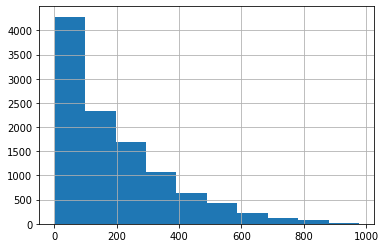

In [10]:
# pandas의 DataFrame의 hist()를 이용해 자전거 대여 모델의 Target 값인 count 칼럼이 정규 분포를 이루는지 확인한다.
y_target.hist()

**count 칼럼 값이 정규 분포가 아닌 0 ~ 200 사이에 왜곡돼 있는 것을 알 수 있다. 이렇게 왜곡된 값을 정규 분포 형태로 바꾸는 가장 일반적인 방법은 로그를 적용해 변환 하는 것이다. 여기서는 넘파이의 log1p()를 이용한다.**

**이렇게 변경된 Target 값을 기반으로 학습하고 예측한 값은 다시 expm1() 함수를 적용해 원래 scale 값으로 원상 복구하면 된다. log1p()를 적용한 'count' 값의 분포를 확인**

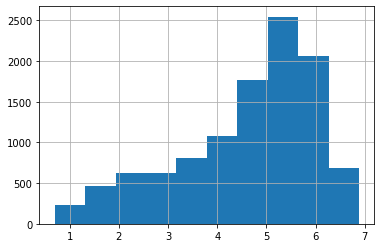

In [11]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

**로그로 Target 값을 변환한 후에 원하는 정규 분포 형태는 아니지만 변환하기 전보다는 왜곡 정도가 많이 향상됐다. 이를 이용해 다시 학습한 후 평가를 진행**

In [12]:
# 타깃 칼럼인 count값을 log1p로 로그 변환
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해 학습/테스트 세트 분할
X_train ,X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression() # 모델 불러오기
lr_reg.fit(X_train, y_train) # 모델 학습
pred = lr_reg.predict(X_test) # 예측 값 산출

# 테스트 데이터 세트의 Target 값은 로그 변환됐으므로 다시 expm1를 스케일 변환
y_test_exp = np.expm1(y_test)

# 예측값 역시 로그 변환된 타깃 기반으로 학습돼 예측됐으므로 다시 expm1로 스케일 변환
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

RMSLE: 1.017, RMSE: 162.594, MSE: 109.286


**RMSLE 오류는 줄어들었지만, RMSE는 오히려 더 늘어났다. 이유가 무엇일까? 각 피처의 회귀 계수 값을 시각화해본다.**

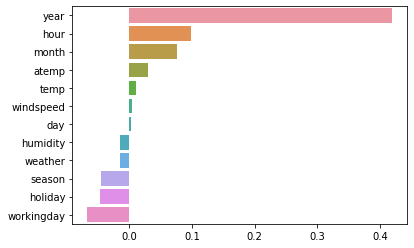

In [13]:
coef = pd.Series(lr_reg.coef_, index = X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x = coef_sort.values, y = coef_sort.index)

**Year 피처의 회귀 계수 값이 독보적으로 큰 값을 가지고 있다. year는 2011년, 2012년 두 개의 값으로 돼 있다.  year에 따라서 자전거 대여 횟수가 크게 영향을 받는다는 것은 납득하기 어렵다. 여름, 가을과 같이 자전거를 타기 좋은 계절이나 낮 시간대 등의 다양한 요소를 제외하고 year의 회귀 계수가 이렇게 큰 이유는 무엇일까?**

> **year 피처는 연도를 뜻하므로 카테고리(Category)형 피처지만, 숫자형 갓으로 돼 있다. 더군다나 아주 큰 값인 2011,2012로 돼 있다. 사이킷런은 카테고리만을 위한 데이터 타입이 없으며, 모두 숫자로 변환해야 한다.**

> **하지만 이처럼 숫자형 카테고리 값을 선형 회귀에 사용할 경우 회귀 계수를 연산할 때 이 숫자형 값에 크게 영향을 받는 경우가 발생할 수 있다**

> **따라서 선형 회귀에서는 이러한 피처 인코딩에 원-핫 인코딩을 적용해 변환해야한다.**

In [14]:
# 판다스의 get_dummies()를 이용해 이러한 year 칼럼을 비롯해, month, hourm holiday,workingday, season, weather
# 칼럼 모두 원-핫 인코딩한 후에 다시 예측 성능을 확인한다.
# 'year', 'month', 'hour', 'season', 'weather' 피처를 원-핫 인코딩

# 'year','month','hour','holiday','workingday','season','weather'을 원-핫 인코딩 수행
X_features_one = pd.get_dummies(X_features, columns=['year','month','hour','holiday',
                                                   'workingday','season','weather'])

In [17]:
# 사이킷런의 선형 회귀 모델인 LinearRegression, Ridge, Lasso 모두 학습해 예측 성능을 확인한다.

# 원-핫 인코딩이 적용된 피처 데이터 세트 기반으로 학습/예측 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_one, y_target_log,
                                                   test_size=0.3, random_state=0)

# 모델과 학습/테스트 데이터 세트를 입력하면 성능 평가 수치를 반환
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train) # 모델 학습
    pred = model.predict(X_test) # 학습된 모델에 X_test 셋을 통해 예측 값 산출
    if is_expm1:
        y_test = np.expm1(y_test) # 실제 값 log 변환을 다시 원래의 단위로
        pred = np.expm1(pred) # 예측 값 log 변환을 다시 원래의 단위로
    print('###', model.__class__.__name__, '###')
    evaluate_regr(y_test, pred)
# end of function get_model_predict

# 모델별로 평가 수행
lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg,ridge_reg,lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.589, RMSE: 97.483, MSE: 63.106
### Ridge ###
RMSLE: 0.589, RMSE: 98.407, MSE: 63.648
### Lasso ###
RMSLE: 0.634, RMSE: 113.031, MSE: 72.658


**원-핫 인코딩을 적용하고 선형 회귀의 예측 성능이 많이 향상 됐다. 원-핫 인코딩된 데이터 세트에서 회귀 계수가 높은 피처를 다시 시각화한다.**

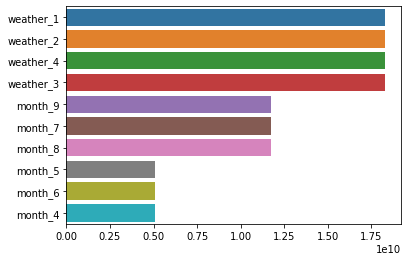

In [18]:
coef = pd.Series(lr_reg.coef_, index=X_features_one.columns) # 각 회귀 계수와 칼럼 이름을 매핑
coef_sort = coef.sort_values(ascending=False)[:10] # 오름차순으로 상위 10개 까지 나열
sns.barplot(x=coef_sort.values, y=coef_sort.index) # 막대 그래프로 시각화

**상식적으로 계절과 월, 날씨 등 자전거를 타는 데 필요한 피처의 회귀 계수가 높아졌다. 이처럼 선형 회귀 수행 시에는 피처를 어떻게 인코딩 하는가가 성능에 중요한 영향을 미칠 수 있다.**

In [20]:
# 이번에는 회귀 트릴를 이용해 예측을 수행한다.
# 앞에서 적용한 Target 값의 로그 변환된 값과 원-핫 인코딩된 피처 데이터 세트를 
# 이용해 랜덤 포레스트, GBM, XGBoost, LightGBM을 순차적으로 성능 평가
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 랜덤 포레스트, GBM, XGBoost, LightGBM 모델별로 평가 수행
rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg= LGBMRegressor(n_estimators=500)

# 각 모델별 get_model_predict를 수행
for model in [rf_reg, gbm_reg, lgbm_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.353, RMSE: 50.782, MSE: 31.498
### GradientBoostingRegressor ###
RMSLE: 0.341, RMSE: 55.773, MSE: 34.332
### LGBMRegressor ###
RMSLE: 0.316, RMSE: 46.473, MSE: 28.777


**앞의 선형 회귀 모델보다 회귀 예측 성능이 개선 됐다. 하지만 이것이 회귀 트리가 선형 회귀 보다 더 나은 성능을 가진다는 의미는 아니다. 데이터 세트의 유형에 따라 결과는 얼마든지 달라질 수 있다.**